In [1]:
import numpy as np


def normalize_band(band):
    band_min = np.nanmin(band)
    band_max = np.nanmax(band)
    if band_max - band_min == 0:
        normalized_band = np.zeros_like(band)
    else:
        # Normalize the data
        normalized_band = (band - band_min) / (band_max - band_min)

    normalized_band = np.where(
        np.isnan(normalized_band),
        np.nan,
        normalized_band.astype(np.float32),
    )

    return normalized_band


def nan_maximum(array1, array2):
    return np.where(
        np.isnan(array1),
        array2,
        np.where(
            np.isnan(array2),
            array1,
            np.maximum(array1, array2),
        ),
    )

In [2]:
import os
import random
from osgeo import gdal

input_file_MSI = "/home/snt/projects_lujun/vitCausalSeries/data/source/remote_sensing/Causal_MSI_2020_with_city.tif"
input_file_SAR = "/home/snt/projects_lujun/vitCausalSeries/data/source/remote_sensing/Causal_SAR_2020.tif"
output_folder = "/home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR"
train_folder = f"{output_folder}/output_patches_time_series_with_city/train"
val_folder = f"{output_folder}/output_patches_time_series_with_city/val"

os.makedirs(output_folder, exist_ok=True)
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

dataset_MSI = gdal.Open(input_file_MSI)
dataset_SAR = gdal.Open(input_file_SAR)


def create_time_band_mapping(dataset):
    width = dataset.RasterXSize
    height = dataset.RasterYSize
    band_count = dataset.RasterCount
    time_band_mapping = {}
    cls_name = None
    for i in range(1, band_count + 1):
        band = dataset.GetRasterBand(i)
        band_name = band.GetDescription() or f"Band_{i}"

        if "_" in band_name:
            time_key = band_name.split("_")[-1]
            if time_key not in time_band_mapping:
                time_band_mapping[time_key] = []
            time_band_mapping[time_key].append((i, band_name))
        else:
            cls_name = (i, band_name)

    return time_band_mapping, band_count, height, width, cls_name


time_band_mapping_MSI, band_count_MSI, height_MSI, width_MSI, cls_name = (
    create_time_band_mapping(dataset_MSI)
)
time_band_mapping_SAR, band_count_SAR, height_SAR, width_SAR, _ = (
    create_time_band_mapping(dataset_SAR)
)

print(height_MSI, width_MSI, height_SAR, width_SAR)

1613 2397 1613 2397


In [5]:
max_pooling_windows = 2
patch_size = 60

time_band_mapping_MSI = dict(sorted(time_band_mapping_MSI.items()))
time_band_mapping_SAR = dict(sorted(time_band_mapping_SAR.items()))
time_span = len(time_band_mapping_MSI)
num_channel_per_time = (band_count_MSI - 1) // time_span

center_width = int(width_MSI * 0.2)
center_height = int(height_MSI * 0.2)

center_x_start = (width_MSI - center_width) // 2
center_y_start = (height_MSI - center_height) // 2

center_x_end = center_x_start + center_width
center_y_end = center_y_start + center_height

patch_index = 0
for y in range(0, height_MSI, patch_size):
    for x in range(0, width_MSI, patch_size):

        if y + patch_size > height_MSI or x + patch_size > width_MSI:
            continue

        if center_x_start <= x < center_x_end and center_y_start <= y < center_y_end:
            is_validation = True
        else:
            is_validation = False

        output_subfolder = val_folder if is_validation else train_folder

        patch_filename = os.path.join(output_subfolder, f"patch_{y}_{x}.tif")
        driver = gdal.GetDriverByName("GTiff")
        patch_dataset = driver.Create(
            patch_filename,
            patch_size,
            patch_size,
            time_span // max_pooling_windows * num_channel_per_time
            + time_span // max_pooling_windows * 2
            + 1,  # 11 MSI + 2 SAR + 1 CLS
            gdal.GDT_Float32,
        )

        idx_total = 1
        for i in range(time_span - 1):
            time_index = i // 2
            if i % 2 == 0:
                time_key = list(time_band_mapping_MSI.keys())[i]
                time_key_next = list(time_band_mapping_MSI.keys())[i + 1]
                band_index_list = time_band_mapping_MSI[time_key]
                band_index_list_next = time_band_mapping_MSI[time_key_next]

                # ADD MSI DATA INFORMATION 11 CHANNELS
                for j in range(len(band_index_list)):
                    (b_idx, b_name) = band_index_list[j]
                    (b_idx_next, b_idx_name) = band_index_list_next[j]

                    band = dataset_MSI.GetRasterBand(b_idx)
                    patch_data = normalize_band(
                        band.ReadAsArray(x, y, patch_size, patch_size)
                    )

                    band_next = dataset_MSI.GetRasterBand(b_idx_next)
                    patch_data_next = normalize_band(
                        band_next.ReadAsArray(x, y, patch_size, patch_size)
                    )

                    output_band = patch_dataset.GetRasterBand(idx_total)
                    # print("Add A MSI channel")
                    # print(idx_total)
                    output_band.WriteArray(nan_maximum(patch_data, patch_data_next))
                    band_description = band.GetDescription()
                    if band_description:
                        output_band.SetDescription(band_description)
                    idx_total += 1

                # ADD SAR DATA INFORMATION 2 CHANNELS
                time_key_SAR = list(time_band_mapping_SAR.keys())[0]
                band_index_list_SAR_0 = time_band_mapping_SAR[time_key_SAR]

                for j in range(len(band_index_list_SAR_0)):
                    if time_index in [0, 1, 2, 3]:
                        time_key_SAR = list(time_band_mapping_SAR.keys())[time_index]
                        band_index_list_SAR = time_band_mapping_SAR[time_key_SAR]
                        (b_idx, b_name) = band_index_list_SAR[j]
                        band = dataset_SAR.GetRasterBand(b_idx)
                        patch_data = normalize_band(
                            band.ReadAsArray(x, y, patch_size, patch_size)
                        )
                        output_band = patch_dataset.GetRasterBand(idx_total)
                        output_band.WriteArray(patch_data)
                        # print("Add A SAR channel")
                        # print(idx_total)
                        idx_total += 1

                    if time_index == 5:
                        time_key_SAR = list(time_band_mapping_SAR.keys())[
                            time_index - 1
                        ]
                        band_index_list_SAR = time_band_mapping_SAR[time_key_SAR]
                        (b_idx, b_name) = band_index_list_SAR[j]
                        band = dataset_SAR.GetRasterBand(b_idx)
                        patch_data = normalize_band(
                            band.ReadAsArray(x, y, patch_size, patch_size)
                        )
                        output_band = patch_dataset.GetRasterBand(idx_total)
                        output_band.WriteArray(patch_data)
                        # print("Add A SAR channel")
                        # print(idx_total)
                        idx_total += 1

                    if time_index == 4:
                        time_key_SAR_last = list(time_band_mapping_SAR.keys())[
                            time_index - 1
                        ]
                        band_index_list_SAR_last = time_band_mapping_SAR[
                            time_key_SAR_last
                        ]

                        (b_idx, b_name) = band_index_list_SAR[j]
                        (b_idx_next, b_idx_name) = band_index_list_SAR_last[j]
                        band = dataset_SAR.GetRasterBand(b_idx)
                        patch_data = normalize_band(
                            band.ReadAsArray(x, y, patch_size, patch_size)
                        )

                        band_next = dataset_SAR.GetRasterBand(b_idx_next)
                        patch_data_next = normalize_band(
                            band_next.ReadAsArray(x, y, patch_size, patch_size)
                        )
                        output_band = patch_dataset.GetRasterBand(idx_total)
                        output_band.WriteArray(nan_maximum(patch_data, patch_data_next))
                        # print("Add A SAR channel")
                        # print(idx_total)
                        idx_total += 1
        # print("Add A CLS channel")
        # print(idx_total)
        out_band = patch_dataset.GetRasterBand(idx_total)
        band = dataset_MSI.GetRasterBand(cls_name[0])
        patch_data = band.ReadAsArray(x, y, patch_size, patch_size)
        out_band.WriteArray(patch_data)
        print(np.unique(patch_data))
        out_band.SetDescription(cls_name[1])
        patch_dataset.FlushCache()
        print(f"已保存时间的所有波段到文件: {patch_filename}")
        patch_dataset = None
        patch_index += 1

/tmp/ipykernel_802981/2623356077.py:5: RuntimeWarning: All-NaN slice encountered
  band_min = np.nanmin(band)
/tmp/ipykernel_802981/2623356077.py:6: RuntimeWarning: All-NaN slice encountered
  band_max = np.nanmax(band)


[ 1.  5. nan]
已保存时间的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/train/patch_0_0.tif
[ 1.  5. nan]
已保存时间的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/train/patch_0_60.tif
[ 1.  5. nan]
已保存时间的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/train/patch_0_120.tif
[ 1.  5. nan]
已保存时间的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/train/patch_0_180.tif
[ 1.  5. nan]
已保存时间的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/train/patch_0_240.tif
[ 1.  5. nan]
已保存时间的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/train/patch_0_300.tif
[ 1.  5. nan]
已保存时间的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/outpu

[ 1.  5. nan]
已保存时间的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/train/patch_0_1920.tif
[ 5. nan]
已保存时间的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/train/patch_0_1980.tif
[ 1.  5. nan]
已保存时间的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/train/patch_0_2040.tif
[ 1.  5. nan]
已保存时间的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/train/patch_0_2100.tif
[ 1.  5. nan]
已保存时间的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/train/patch_0_2160.tif
[nan]
已保存时间的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/train/patch_0_2220.tif
[nan]
已保存时间的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_t

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0014583296..1.0663753].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014184042..1.0105354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.063905574..1.0315292].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11148898..0.9868867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19145325..0.73391634].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12680934..0.6803851].


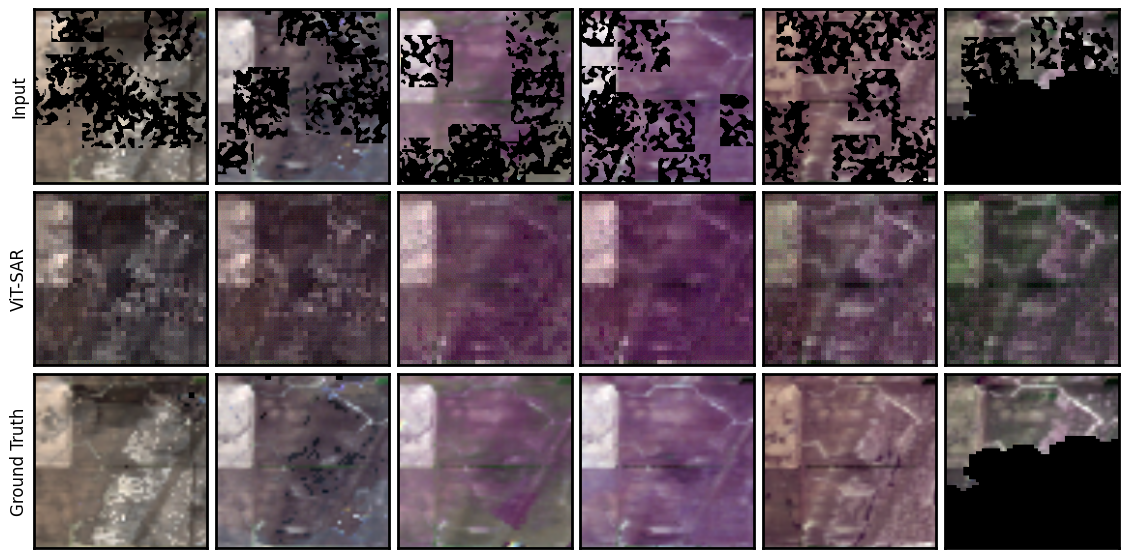

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal


def read_tiff(file_path):
    """Read a TIFF file and return its image data as a numpy array."""
    dataset = gdal.Open(file_path)
    if not dataset:
        raise FileNotFoundError(f"Unable to open the file: {file_path}")
    band_count = dataset.RasterCount
    bands_data = []
    for i in range(1, band_count + 1):
        band = dataset.GetRasterBand(i)
        band_data = band.ReadAsArray()
        bands_data.append(band_data)

    image = np.stack(bands_data, axis=0)
    return image


def process_tiff(tiff, channel_list):
    """Process the TIFF data: split channels and extract pseudo-color images."""
    channels, h, w = tiff.shape
    time_span = int(channels / 11)
    images = np.split(tiff, [11 * (i + 1) for i in range(time_span)], axis=0)
    time_series_images = []
    for i, image in enumerate(images[:-1]):
        image = np.transpose(image, (1, 2, 0))
        pseudo_color_image = image[:, :, channel_list]
        time_series_images.append(pseudo_color_image)
    return time_series_images


# Read and process masked outputs
pos = "_1500_780_"
target_folder = "my_experiment_20250108-121717_reconstruction"
output_tiff = read_tiff(
    f"/home/snt/projects_lujun/vitCausalSeries/data/training/logs/{target_folder}/masked_outputs/patch{pos}output.tiff"
)
time_series_images_outputs = process_tiff(output_tiff, channel_list=[3, 2, 1])

# Read and process masked targets
target_tiff = read_tiff(
    f"/home/snt/projects_lujun/vitCausalSeries/data/training/logs/{target_folder}/masked_targets/patch{pos}target.tiff"
)
time_series_images_targets = process_tiff(target_tiff, channel_list=[3, 2, 1])

# Read and process masked targets
input_tiff = read_tiff(
    f"/home/snt/projects_lujun/vitCausalSeries/data/training/logs/{target_folder}/masked_inputs/patch{pos}input.tiff"
)
time_series_images_inputs = process_tiff(input_tiff, channel_list=[3, 2, 1])


# Plotting the results
fig, axes = plt.subplots(
    3,
    len(time_series_images_outputs),
    figsize=(14, 7),
    gridspec_kw={"hspace": 0.05, "wspace": 0.05},
)
for ax in axes.flatten():
    ax.spines["top"].set_color("black")
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    ax.spines["right"].set_color("black")
    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.set_xticks([])
    ax.set_yticks([])

# # Masked Outputs
for j in range(len(time_series_images_inputs)):
    axes[0, j].imshow(time_series_images_inputs[j], cmap="gray")
    axes[0, j].axis("on")

# # Masked Outputs
for j in range(len(time_series_images_outputs)):
    axes[1, j].imshow(time_series_images_outputs[j], cmap="gray")
    axes[1, j].axis("on")

# # Masked Targets
for j in range(len(time_series_images_targets)):
    axes[2, j].imshow(time_series_images_targets[j], cmap="gray")
    axes[2, j].axis("on")


axes[0, 0].set_ylabel("Input", fontsize=12, color="black")
axes[1, 0].set_ylabel("ViT-SAR", fontsize=12, color="black")
axes[2, 0].set_ylabel("Ground Truth", fontsize=12, color="black")

plt.savefig("output_plot.svg", format="svg")

plt.show()

In [93]:
def extract_positions(folder_path):
    file_names = os.listdir(folder_path)

    positions = []

    for file_name in file_names:
        if file_name.startswith("patch_") and file_name.endswith("_target.tiff"):
            position = file_name[6:-10]
            positions.append(f"_{position}_")

    return positions


folder_path = "/home/snt/projects_lujun/vitCausalSeries/data/training/logs/my_experiment_20250107-225602_reconstruction/masked_targets"
positions = extract_positions(folder_path)
print(positions)

['_60_1980_t_', '_1020_1200_t_', '_360_120_t_', '_840_1440_t_', '_60_1740_t_', '_840_1980_t_', '_0_240_t_', '_1020_1320_t_', '_480_480_t_', '_900_1080_t_', '_180_1380_t_', '_1320_360_t_', '_1140_1440_t_', '_0_2160_t_', '_1080_840_t_', '_420_240_t_', '_1080_2220_t_', '_1500_1020_t_', '_1320_1140_t_', '_1380_1680_t_', '_300_900_t_', '_1200_2280_t_', '_1500_480_t_', '_1440_1860_t_', '_1140_480_t_', '_240_1620_t_', '_300_360_t_', '_1500_600_t_', '_1140_1980_t_', '_1320_900_t_', '_660_1800_t_', '_360_1320_t_', '_1260_2280_t_', '_960_540_t_', '_720_1620_t_', '_840_1680_t_', '_1380_1140_t_', '_1140_360_t_', '_300_0_t_', '_240_660_t_', '_1320_600_t_', '_840_1500_t_', '_420_1500_t_', '_1140_660_t_', '_1140_540_t_', '_1260_840_t_', '_1320_300_t_', '_660_1200_t_', '_840_900_t_', '_60_60_t_', '_1260_0_t_', '_960_1200_t_', '_1500_420_t_', '_540_660_t_', '_1320_1680_t_', '_180_660_t_', '_180_1620_t_', '_960_600_t_', '_660_2280_t_', '_840_2040_t_', '_1200_540_t_', '_240_0_t_', '_1200_1380_t_', '_1440

## See Full Graph

In [20]:
def stitch_patches(patch_folder, patch_size, output_shape, time_span, darken_val=False):
    stitched_image = np.zeros(
        (time_span * 13 + 1, output_shape[0], output_shape[1]), dtype=np.float32
    )
    for root, dirs, files in os.walk(patch_folder):
        for patch_file in files:
            if patch_file.endswith(".tif"):
                y, x = map(
                    int, patch_file.replace("patch_", "").replace(".tif", "").split("_")
                )
                patch = read_tiff(os.path.join(root, patch_file))

                # Darken patches in the validation folder
                if darken_val and "val" in root:
                    patch *= 0.5  # Reduce brightness by 50%

                stitched_image[:, y : y + patch_size, x : x + patch_size] = patch
    return stitched_image


input_file = "/home/snt/projects_lujun/vitCausalSeries/data/source/remote_sensing/Causal_MSI_2020_with_city.tif"
dataset = gdal.Open(input_file)
if not dataset:
    raise ValueError(f"Unable to open file {input_file}")

width = dataset.RasterXSize
height = dataset.RasterYSize

tiff = read_tiff(
    "/home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/train/patch_0_0.tif"
)

channel_list = [3, 2, 1]
channels, h, w = tiff.shape

train_folder = "/home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/train"
val_folder = "/home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/val"

folder_path = "/home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city"
output_width, output_height = (
    width // patch_size * patch_size,
    height // patch_size * patch_size,
)
time_span = int((channels) // 13)

# Stitch train patches
stitched_train_image = stitch_patches(
    train_folder, patch_size, (output_height, output_width), time_span
)

# Stitch validation patches and darken them
stitched_val_image = stitch_patches(
    val_folder, patch_size, (output_height, output_width), time_span, darken_val=True
)

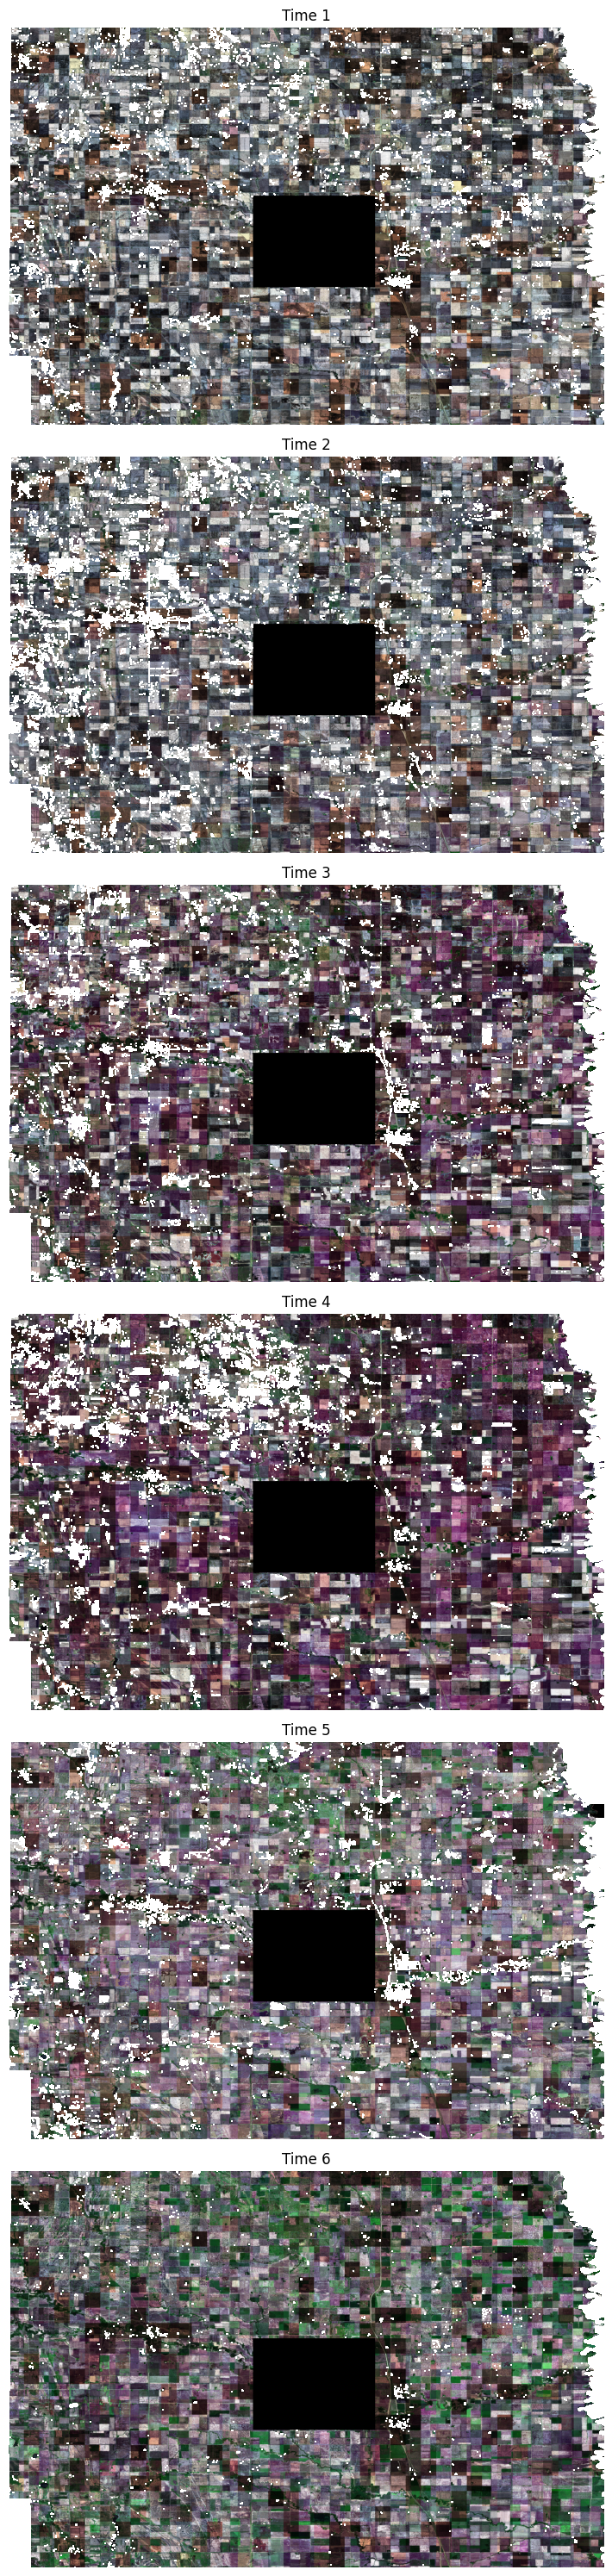

In [21]:
import matplotlib.pyplot as plt


def visualize_time_series(image, time_span, channel_list):
    channels, h, w = image.shape
    images = np.split(image, [13 * (i + 1) for i in range(time_span)], axis=0)
    time_series_images = []

    for i, img in enumerate(images[:-1]):
        img = np.transpose(img, (1, 2, 0))
        pseudo_color_image = img[:, :, channel_list]
        time_series_images.append(pseudo_color_image)

    fig, axes = plt.subplots(
        len(time_series_images), 1, figsize=(10, 30)
    )  # 调整为竖直排列

    for j in range(len(time_series_images)):
        axes[j].imshow(time_series_images[j])  # 显示图像
        axes[j].axis("off")  # 隐藏坐标轴
        axes[j].set_title(f"Time {j+1}")  # 设置标题

    plt.tight_layout()
    plt.show()


# 可视化拼接后的训练集影像
channel_list = [3, 2, 1]  # RGB通道选择
visualize_time_series(stitched_train_image, time_span, channel_list)

# See ALL CLS labels

In [6]:
def read_tiff(file_path):
    dataset = gdal.Open(file_path)
    if not dataset:
        raise FileNotFoundError(f"Unable to open the file: {file_path}")
    band_count = dataset.RasterCount
    bands_data = []
    for i in range(1, band_count + 1):
        band = dataset.GetRasterBand(i)
        band_name = band.GetDescription()
        band_data = band.ReadAsArray()
        bands_data.append(band_data)

    image = np.stack(bands_data, axis=0)
    return image


tiff = read_tiff(
    "/home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/train/patch_0_240.tif"
)

np.unique(tiff[-1, :, :])

array([ 0.,  1., nan], dtype=float32)

In [7]:
max_pooling_windows = 2
patch_size = 60


def stitch_patches(patch_folder, patch_size, output_shape, time_span, darken_val=False):
    stitched_image = np.zeros((output_shape[0], output_shape[1]), dtype=np.float32)
    for root, dirs, files in os.walk(patch_folder):
        for patch_file in files:
            if patch_file.endswith(".tif"):
                y, x = map(
                    int, patch_file.replace("patch_", "").replace(".tif", "").split("_")
                )
                patch = read_tiff(os.path.join(root, patch_file))[-1, :, :]
                stitched_image[y : y + patch_size, x : x + patch_size] = patch
    return stitched_image


input_file = "/home/snt/projects_lujun/vitCausalSeries/data/source/remote_sensing/Causal_MSI_2020_with_city.tif"
dataset = gdal.Open(input_file)
if not dataset:
    raise ValueError(f"Unable to open file {input_file}")

width = dataset.RasterXSize
height = dataset.RasterYSize

tiff = read_tiff(
    "/home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/train/patch_0_0.tif"
)

channel_list = [3, 2, 1]
channels, h, w = tiff.shape

train_folder = "/home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/train"
val_folder = "/home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/val"

folder_path = "/home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city"
output_width, output_height = (
    width // patch_size * patch_size,
    height // patch_size * patch_size,
)
time_span = int((channels) // 13)

# Stitch train patches
stitched_train_image = stitch_patches(
    train_folder, patch_size, (output_height, output_width), time_span
)

# Stitch validation patches and darken them
stitched_val_image = stitch_patches(
    val_folder, patch_size, (output_height, output_width), time_span
)

stitched_image = stitch_patches(
    folder_path, patch_size, (output_height, output_width), time_span
)

NameError: name 'time_sp' is not defined

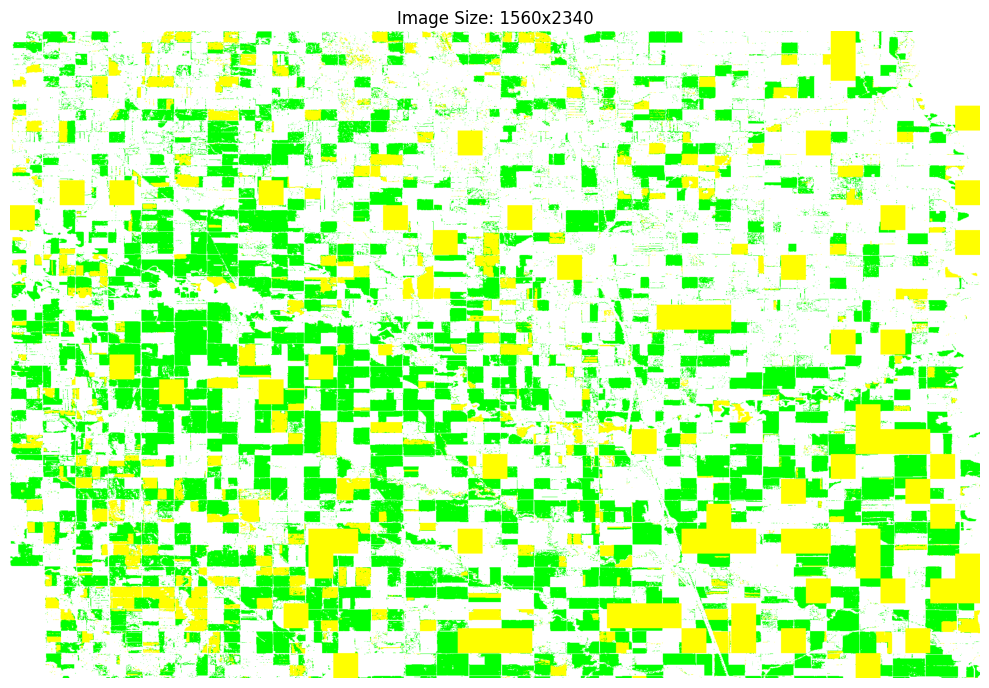

In [62]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def visualize_time_series(image):
    # Get the height and width of the image
    h, w = image.shape

    # Create a custom colormap:
    # NaN -> White, 0.0 -> Yellow, 1.0 -> Green
    colors = [
        (1, 1, 1),  # White for NaN
        (1, 1, 0),  # Yellow for 0.0
        (0, 1, 0),  # Green for 1.0
    ]

    # Create the colormap
    cmap = ListedColormap(colors)

    # Replace NaNs with a unique value (-1) to map to White (background)
    image_nan_replaced = np.nan_to_num(image, nan=-1)  # Use -1 for NaN to map to White

    # Create a figure and axes
    fig, axes = plt.subplots(1, 1, figsize=(10, 10))

    # Display the image with the custom colormap
    axes.imshow(image_nan_replaced, cmap=cmap)

    # Set the title of the plot (optional)
    axes.set_title(f"Image Size: {h}x{w}")

    # Remove axes ticks
    axes.axis("off")

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()


visualize_time_series(stitched_image)